In [1]:
import numpy as np
import scipy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import astropy.io.ascii as asci
from helper import phys

In [2]:
from helper.specread import get_keck, gaplinelist, get_keck, get_hstspec, get_p200, get_ltspec
from helper.specread import add_telluric_circle, pblines
from helper.specplot_func import get_vvyy, add_tick,  plot_mask_gal_lines, measure_line_index, measure_abs_velocity
from helper.specplot_func import host_subtraction
from helper.specconvolve import convolve_with_constant_velocity_kernel
from allsn_info import get_at2019dge

In [4]:
import matplotlib
import matplotlib.pyplot as plt
fs= 10
matplotlib.rcParams['font.size']=fs

%matplotlib notebook

In [5]:
result = get_at2019dge()
z =result["z"]
t0max = result["t_max"]
ebv = result["ebv"]# galactic extinction
lc = result['tb']
lc = lc[lc.instrument!='P60+SEDM']
lcdet = lc.sort_values(by = ['mjd'])

In [6]:
dt1 = get_keck(z=z, date = "20190412_Keck1_v2", vkernel = 200)
dt0 = get_keck(z=z, date = "20190704_Keck1_v1", vkernel = 200)
dt7 = get_keck(z=z, date = "20190928_Keck1_v1", vkernel = 200)
dt6 = get_keck(z=z, date = "20190831_Keck1_v1", vkernel = 200)
dt8 = get_keck(z=z, date = "20200218_Keck1_v2", vkernel = 200)
dt2 = get_p200(z=z)
dt3 = get_ltspec(date = '0410', z=z)
dt4 = get_ltspec(date = '0409', z=z)
dt5 = get_hstspec(z=z)

/Users/yuhanyao/Documents/GitHub/AT2019dge/playground/helper/specread.py:294: RuntimeWarning: invalid value encountered in log
  dt["ln_spec_obs"] = np.log(dt['spec_obs0'])
/Users/yuhanyao/Documents/GitHub/AT2019dge/playground/helper/specread.py:350: RuntimeWarning: invalid value encountered in log
  dt["ln_spec_obs"] = np.log(dt['spec_obs0'])


In [7]:
yaolist = gaplinelist(z=0)
H_list = yaolist['H_list']
FeII_list = yaolist['FeII_list']
HeI_list = yaolist['HeI_list']
HeII_list = yaolist['HeII_list']
OIII_list = yaolist['OIII_list']
OII_list = yaolist['OII_list']
OI_list = yaolist['OI_list']
SIII_list = yaolist['SIII_list']
SII_list = yaolist['SII_list']
NII_list = yaolist['NII_list']
CaII_list = yaolist['CaII_list']
NeIII_list = yaolist['NeIII_list']
ArIII_list = yaolist["ArIII_list"]
MgII_list = yaolist["MgII_list"]
CIII_list = yaolist["CIII_list"]
NIII_list = yaolist["NIII_list"]

select regions that should contain only galaxy light

In [8]:
gal_regions = np.array([[3350, 3900, 4200, 4420, 4600, 5150, 5540, 6030, 6400, 6860, 7540, 8250, 8870, 9400, 9800],
                        [3650, 4070, 4300, 4520, 4800, 5250, 5680, 6110, 6500, 6960, 7700, 8400, 9000, 9490, 10000]])

In [9]:
def visualize_subtraction(dt0, dt8):
    plt.figure(figsize = (10,6))
    ax = plt.subplot(111)
    x1_sub, y1_sub = host_subtraction(dt0['wave_con'], dt0['spec_con'], 
                                      dt8['wave_con'], dt8['spec_con'], gal_regions, fixb = True, plotax = ax)
    tup = 1.5e-16
    tbottom = -1e-16
    xoff = -30
    yoff = 0.06e-16
    ax.plot([OI_list[1], OI_list[1]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([OI_list[2], OI_list[2]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(OI_list[1]+xoff, tup+yoff, "[O I]", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.plot([CaII_list[2], CaII_list[2]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[3], CaII_list[3]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(CaII_list[3]+xoff*1.6, tup+yoff, "[Ca II]", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.plot([HeI_list[2], HeI_list[2]], [tbottom, tup], color='forestgreen', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[2]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "forestgreen")

    ax.plot([HeI_list[3], HeI_list[3]], [tbottom, tup], color='b', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[3]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "b", zorder = 6)

    ax.plot([HeI_list[4], HeI_list[4]], [tbottom, tup], color='crimson', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[4]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "crimson", zorder = 6)

    ax.plot([CaII_list[4], CaII_list[4]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[5], CaII_list[5]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[6], CaII_list[6]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(CaII_list[5]+xoff, tup+yoff, "Ca II", rotation=90, fontsize = fs-1, color = "darkcyan")
    ax.set_ylim(-5e-17, 2e-16)
    return x1_sub, y1_sub

<IPython.core.display.Javascript object>


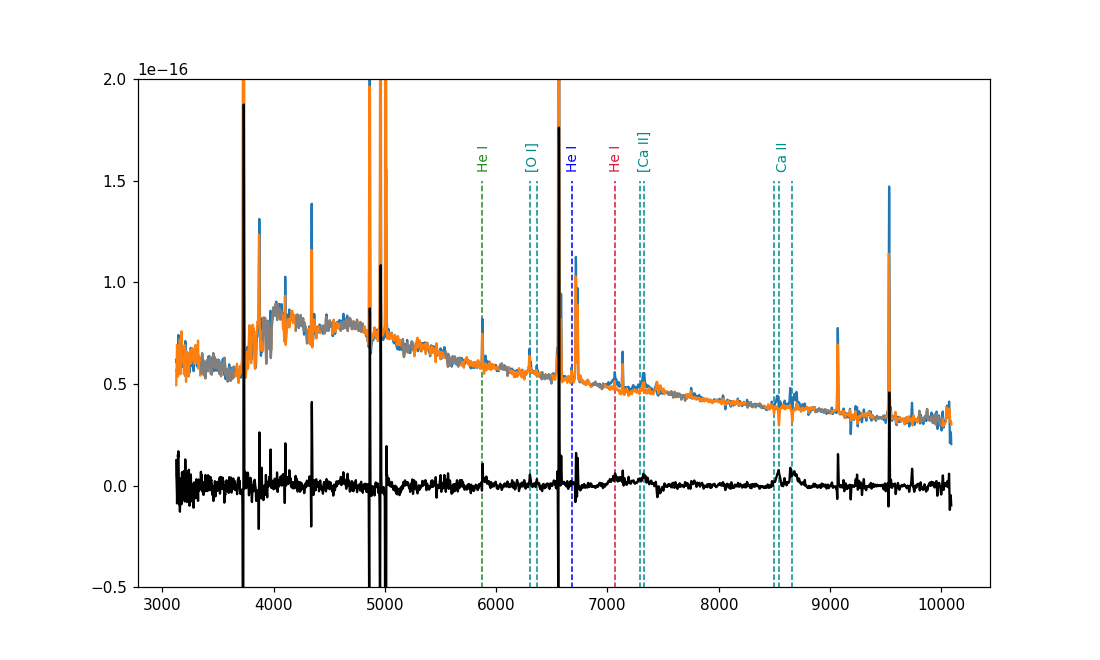

0
[1.01938184 1.01093351 0.98296946 0.97850263 1.0294136  1.00919348
 0.99875088 0.9915847  1.01678062 0.96776728 0.97765187 0.97488164
 0.99507225 1.02316901 1.03603009]


In [12]:
x1_sub, y1_sub = visualize_subtraction(dt0, dt8)

In [13]:
ww1, ff1 = convolve_with_constant_velocity_kernel(x1_sub, y1_sub, 300)

In [14]:
sp1 = pd.read_csv("../data/otherSN/SN2011hw/phase60")
sp2 = pd.read_csv("../data/otherSN/SN2015G/phase92")
sp3 = pd.read_csv("../data/otherSN/SN2006jc/phase74")

In [15]:
wv1 = sp1["wavelength"].values / (1+0.023)
fl1 = sp1["flux"].values
wv1_, fl1_ =  convolve_with_constant_velocity_kernel(wv1, fl1, 300)

wv2 = sp2["wavelength"].values/ (1+0.00475)
fl2 = sp2["flux"].values
wv2_, fl2_ =  convolve_with_constant_velocity_kernel(wv2, fl2, 300)

wv3 = sp3["wavelength"].values/ (1+0.0035)
fl3 = sp3["flux"].values
wv3_, fl3_ =  convolve_with_constant_velocity_kernel(wv3, fl3, 300)

<IPython.core.display.Javascript object>


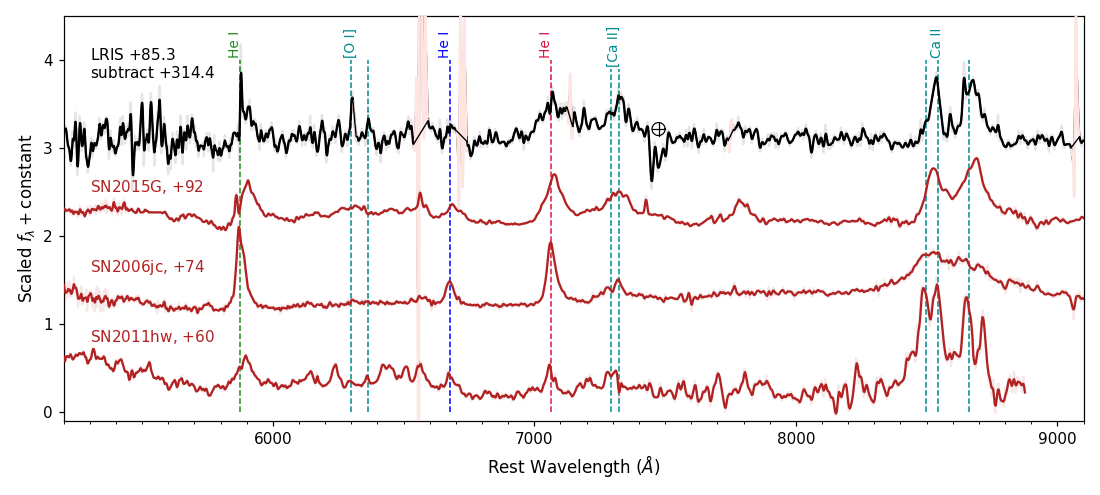

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator


In [16]:
    fig = plt.figure(figsize=(10, 4.5))
    ax = plt.subplot(111)
    
    ax.plot(x1_sub, y1_sub*1e+17+0.1, 'k', alpha = 0.1)
    plot_mask_gal_lines(ax, x1_sub, y1_sub*1e+17+0.1, plotfinal = False)
    ax.plot(ww1, ff1*1e+17+0.1, 'k', alpha = 1)
    plot_mask_gal_lines(ax, ww1, ff1*1e+17+0.1, plotfinal = True)
    
    xtext = 5300
    ax.text(xtext, 1.0, 'LRIS $+%.1f$'%dt0["phase"], zorder = 6, fontsize = fs)
    ax.text(xtext, 0.8, 'subtract $+%.1f$'%dt8["phase"], zorder = 6, fontsize = fs)
    
    ax.set_ylim(-3.1, 1.5)
    ax.set_xlim(5200, 9100)
    
    ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    ax.xaxis.set_minor_locator(plt.MultipleLocator(100))
    ax.set_xlabel('Rest Wavelength ('+r'$\AA$'+')', fontsize = fs+1)
    #ax.set_ylabel(r'$f_{\lambda}$'+ " ("+r"$10^{-17}\,{\rm erg\,s^{-1}\, cm^{-2}}$"+ ")")
    ax.set_ylabel("Scaled "+r'$f_{\lambda}+$'+ "constant", fontsize = fs+1)
    plt.xticks(fontsize = fs)
    plt.yticks(fontsize = fs)
    
    tup = 1
    tbottom = -3
    xoff = -30
    yoff = 0.06
    ax.plot([OI_list[1], OI_list[1]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([OI_list[2], OI_list[2]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(OI_list[1]+xoff, tup+yoff, "[O I]", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.plot([CaII_list[2], CaII_list[2]], [tbottom, tup-0.1], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[3], CaII_list[3]], [tbottom, tup-0.1], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(CaII_list[3]+xoff*1.6, tup+yoff-0.1, "[Ca II]", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    ax.plot([HeI_list[2], HeI_list[2]], [tbottom, tup], color='forestgreen', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[2]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "forestgreen")

    ax.plot([HeI_list[3], HeI_list[3]], [tbottom, tup], color='b', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[3]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "b", zorder = 6)

    ax.plot([HeI_list[4], HeI_list[4]], [tbottom, tup], color='crimson', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(HeI_list[4]+xoff*1.6, tup+yoff, "He I", rotation=90, fontsize = fs-1, color = "crimson", zorder = 6)

    ax.plot([CaII_list[4], CaII_list[4]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[5], CaII_list[5]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.plot([CaII_list[6], CaII_list[6]], [tbottom, tup], color='darkcyan', linestyle='--', linewidth = 1., zorder = 1)
    ax.text(CaII_list[5]+xoff, tup+yoff, "Ca II", rotation=90, fontsize = fs-1, color = "darkcyan")
    
    color = "firebrick"
    ax.plot(wv2, fl2*8-1, zorder = 6, color = color, alpha = 0.1)
    ax.plot(wv2_, fl2_*8-1, zorder = 6, color = color, alpha = 1)
    ax.text(xtext, -0.5, 'SN2015G, $+92$', color = color, fontsize = fs)
    
    ax.plot(wv1, fl1*5e+15-2.9, zorder = 6, color = color, alpha = 0.1)
    ax.plot(wv1_, fl1_*5e+15-2.9, zorder = 6, color = color, alpha = 1)
    ax.text(xtext, -2.2, 'SN2011hw, $+60$', color = color, fontsize = fs)
    
    ax.plot(wv3, fl3*1.2e+16-2, zorder = 6, color = color, alpha = 0.1)
    ax.plot(wv3_, fl3_*1.2e+16-2, zorder = 6, color = color, alpha = 1)
    ax.text(xtext, -1.4, 'SN2006jc, $+74$', color = color, fontsize = fs)
    
    
    add_telluric_circle(ax, 7475, 0.22, rx=25, ry = 0.08*4.6/5, ls=0.8)
    ax.set_yticklabels([-1, 0, 1, 2, 3, 4])
    plt.tight_layout()
    plt.savefig("../paper/figures/spec_host_subtracted.pdf")

In [18]:
## End